
# Seismic Denoising using Deep Denoising Autoencoders (DDAE)

## Introduction


In this tutorial, we will explore how Deep Learning, specifically Deep Denoising Autoencoders (DDAE), can be used for this denoising process. We'll walk through the steps of loading and visualizing seismic data, setting up the DDAE, training it on synthetic data, and evaluating its performance.

Let's get started!



## Setup

Before diving into the data and modeling, let's set up our environment by importing the necessary libraries and tools.


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tools import *
from PlotSeis import PlotSeis
from ModelGenSeis import autoencoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import reduce_mean
from tensorflow.image import ssim
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf

2023-08-14 15:10:33.279242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



## Data Exploration

I like this tutorial because it is also working with seismic sgy data- even though it has a lot of built in functions (both a plus and minus) we can sort of see the whole process in action. 


Let's load and visualize our synthetic seismic data to understand its structure and the nature of noise present in it.

Patchify is a Python library that allows users to split images into smaller patches and later reconstruct the original image from these patches. It's particularly useful in deep learning when large images need to be fed into a model in smaller chunks or when working with limited memory.

In [1]:
!pip install patchify 


We start by loading in both clean and noisy data- this data  i created by running one of the other scripts but lets leave that out for now 




In [11]:
import numpy as np
clean_signal_HF = np.load('data/clean_signal.npy')
# noise_HF = np.load('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/data/synth/n.npy')
noisy_signal_HF = np.load('data/noisy_signal.npy')


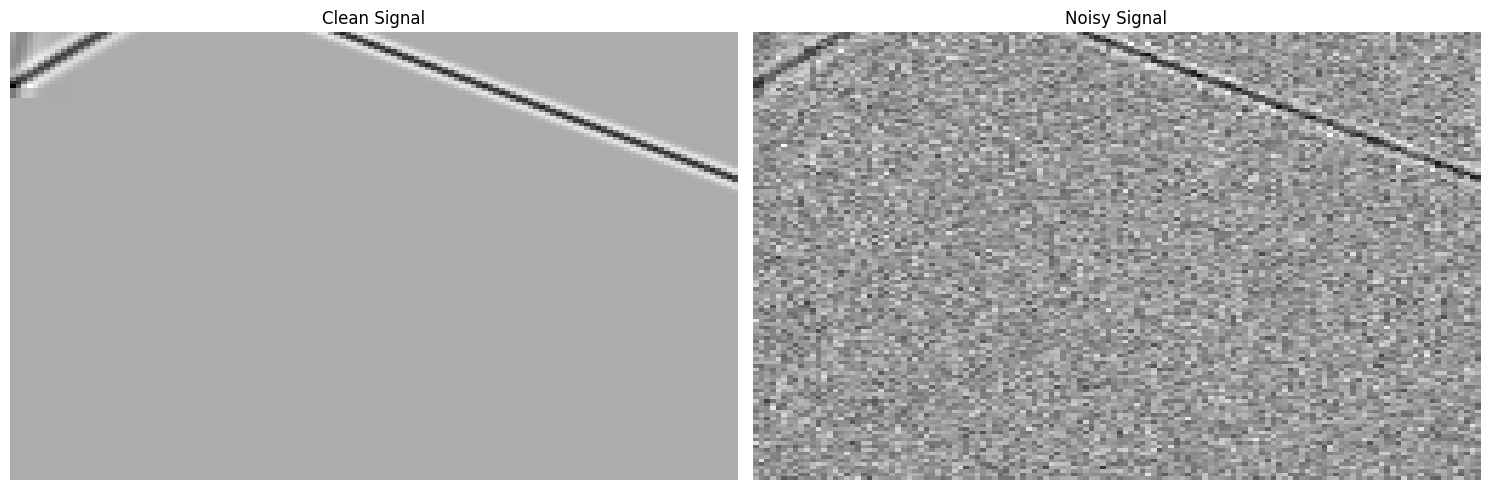

In [15]:
import numpy as np
import matplotlib.pyplot as plt

clean_signal_HF = np.load('data/clean_signal.npy')
noisy_signal_HF = np.load('data/noisy_signal.npy')

# Choose an index to visualize (e.g., index 0)
index_to_visualize = 0

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot clean signal
axs[0].imshow(clean_signal_HF[index_to_visualize], cmap='gray', aspect='auto')
axs[0].set_title('Clean Signal')
axs[0].axis('off')

# Plot noisy signal
axs[1].imshow(noisy_signal_HF[index_to_visualize], cmap='gray', aspect='auto')
axs[1].set_title('Noisy Signal')
axs[1].axis('off')

plt.tight_layout()
plt.show()



### 1 Rescaling seismic data 

Any time we work with seismic data we first need to rescale the images so that they are all of the same size
this is helpful for testing,gradient descent etc... 


 >>The scaling process implemented using the StandardScaler from the sklearn.preprocessing module standardizes the image data by subtracting the mean and dividing by the standard deviation. This results in the data having a mean of 0 and a standard deviation of 1, which is a common transformation used to standardize features.

In [20]:
def scale(data, type, scaler=None): 
    scaled_data = []
    if type == 'train':
        scaler = StandardScaler()
        for i in range(data.shape[0]):
            scaled_image = scaler.fit_transform(data[i])
            scaled_data.append(scaled_image)
        return np.array(scaled_data), scaler
    if type == 'test':
        scaled_data = []
        for i in range(data.shape[0]):
            scaled_image = scaler.transform(data[i])
            scaled_data.append(scaled_image)
        return np.array(scaled_data)


In [21]:
clean_signal_HF_scl,scaler_NS = scale(clean_signal_HF,'train')
noisy_signal_HF_scl,scaler_S = scale(noisy_signal_HF,'train')

In [22]:
print(np.std(clean_signal_HF[100]))
print(np.std(clean_signal_HF_scl[100]))

0.28294924419330153
0.9999999999999996


So we see that the cleaned data has a std of 1 which will be helpful moving forward- its essentially standardization (mean zero std 1)- we can see the effect of scaling here 

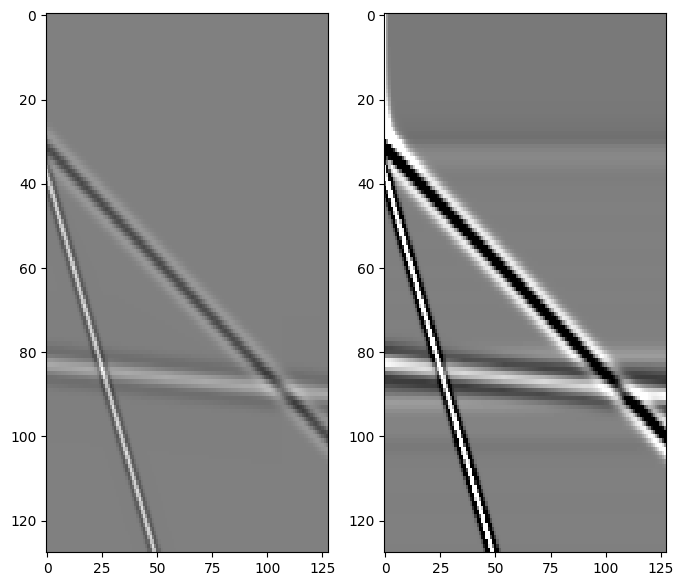

In [24]:
PlotSeis([clean_signal_HF,clean_signal_HF_scl],num=13)

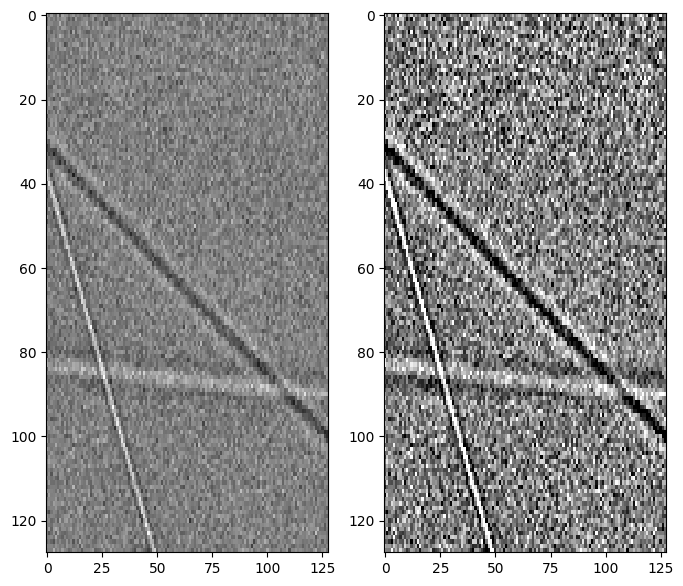

In [26]:
PlotSeis([noisy_signal_HF,noisy_signal_HF_scl],num=13)

Notice how rescaling itself does a lot for cleaning the data 

### 2 Signal to noise Metric 
 Peak Signal-to-Noise Ratio (PSNR) for a set of noisy and clean seismic images. PSNR is a metric often used to measure the quality of a denoised image by comparing it to the original (clean) image.

  A higher PSNR value indicates lower noise and better image quality. The range of PSNR values is typically between 0 and infinity, with higher values indicating better quality.






In [27]:
psnr = []
num_img=100
for i in range(num_img):
    psnr.append(PSNR(clean_signal_HF[i],noisy_signal_HF[i]))
print(np.min(psnr),np.max(psnr))

11.33216049957031 20.941979344381423


The PSNR values obtained from the range of 11 to 20.9 suggest that the quality of the denoised images is not very high. Meaning there is significant noise present in these images

### 03 Generating training and testing data
Lets split up the data into 2/3 train 1/3 test

In [37]:
NS_train, NS_test, S_train, S_test = train_test_split(noisy_signal_HF_scl,clean_signal_HF_scl, test_size=0.2, random_state = 21)


### Preparation of Image Windows for CNN-based Denoising:

The function prep_windows is designed to prepare seismic data for processing by a Convolutional Neural Network (CNN) designed for denoising. CNNs, when used for image denoising, often work best on smaller patches or "windows" of the image rather than the entire image. This approach offers several advantages: it can reduce computational requirements, improve training efficiency, and allow the network to focus on localized features and noise patterns.

The prep_windows function takes in the seismic data (data) and a specified window size (w). It then breaks down each seismic image into smaller, non-overlapping windows or patches of size w x w. The img2windows function assists in this task, ensuring each image is segmented into these smaller patches.

After segmenting the images into windows, these windows are reshaped and stacked, effectively creating a dataset where each entry is a w x w patch of the original images. This dataset is then converted into a tensor format suitable for input into a TensorFlow-based CNN.

In [33]:
def prep_windows(data, w):
    windows = []
    
    # Check if data is 4D, if not, just use 2D slicing
    if len(data.shape) == 4:
        for iImg in range(data.shape[0]):
            windows.append(img2windows(data[iImg,:,:,0], w, w))
    else:
        for iImg in range(data.shape[0]):
            windows.append(img2windows(data[iImg,:,:], w, w))

    windows = np.array(windows)
    windows_resh = tf.convert_to_tensor(windows.reshape(windows.shape[0] * windows.shape[1], w, w, 1))
    return windows, windows_resh


In this case we created 32x32 patches

In [38]:
w=32
NS_train_conv_w32, NS_train_conv_resh_w32 = prep_windows(NS_train,w=w)
NS_test_conv_w32, NS_test_conv_resh_w32 = prep_windows(NS_test,w=w)
S_train_conv_w32, S_train_conv_resh_w32 = prep_windows(S_train,w=w)
S_test_conv_w32, S_test_conv_resh_w32 = prep_windows(S_test,w=w)



Now we have a bunch of windows that have been reshaped and ready to be fit into the model - so we can look at the windows - its like we are zooming into a single patch 

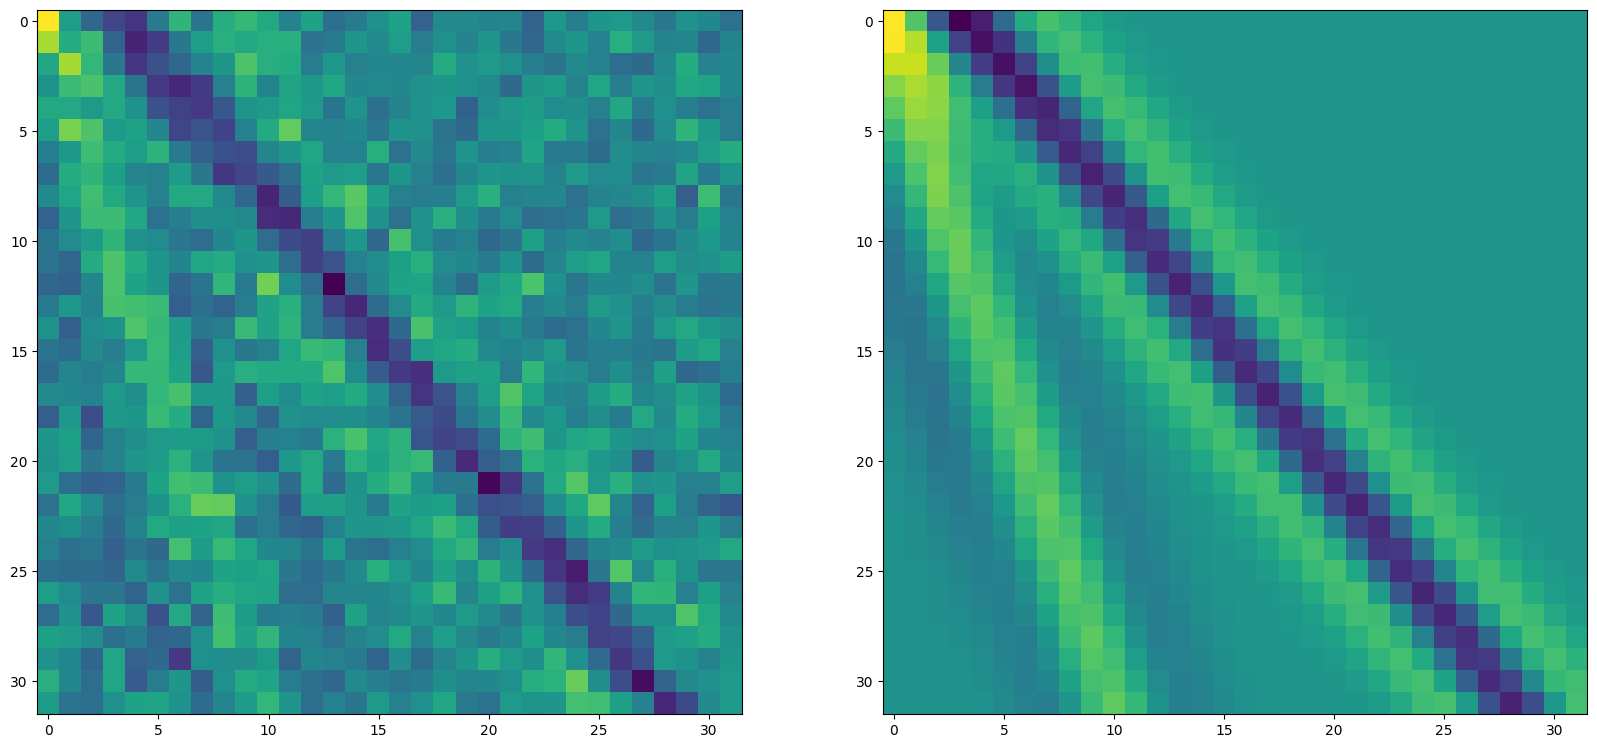

In [42]:
num = 50
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(NS_train_conv_resh_w32[num,:,:,0])

plt.subplot(1,2,2)
plt.imshow(S_train_conv_resh_w32[num,:,:,0])



## Padding 


Probably wortwhile reading this on why padding is important 
 https://www.geeksforgeeks.org/cnn-introduction-to-padding/#:~:text=padding%20is%20a%20technique%20used,input%20feature%20map%20before%20convolution.

I just asekd chatGPT and this is what it told me
### Importance of Padding in Denoising CNNs

Padding is a crucial step in the convolutional processing of images, especially for denoising applications using Convolutional Neural Networks (CNNs). Here are the key reasons:

- **Edge Information Preservation:** Pixels on the edges and corners of an image are covered by fewer filter positions during convolution. Padding ensures each pixel gets adequate coverage, preserving edge information and ensuring effective noise removal at boundaries.
  
- **Maintaining Spatial Dimensions:** Without padding, spatial dimensions shrink after each convolution. Padding allows "same" convolutions, preserving the original spatial context, essential for denoising tasks.

- **Avoiding High-Frequency Artifacts:** Convolution at image boundaries can introduce artifacts without proper padding. Modes like 'REFLECT' or 'SYMMETRIC' prevent such issues, ensuring smooth boundary values.

- **Increasing Network Depth:** Padding supports deeper networks without significant reductions in spatial dimensions. Deeper networks can capture more complex features, aiding in challenging denoising tasks.

- **Enhancing Contextual Information:** Padding ensures pixels, especially at edges, have a broader contextual view, aiding the network in making informed denoising decisions.

In conclusion, padding is vital for effective CNN-based denoising, ensuring preserved information,



In [43]:
def pad(data, win_size):
  padded_data = []
  half = int(win_size/2)
  paddings = tf.constant([[half,half,], [half,half]],dtype=tf.int32)
  for i in range(data.shape[0]):
    temp = tf.pad(tf.reshape(data[i],(win_size,win_size)),paddings,mode='REFLECT')
    padded_data.append(tf.reshape(temp,(win_size*2, win_size*2,1)))

  return tf.convert_to_tensor(np.array(padded_data))

### Looking at autoencoder models

Okay im gonna look at it and try and understand how a model looks 

In [45]:
### Creating an autoencoder model
import tensorflow as tf

# Load the model
loaded_model = tf.keras.models.load_model('models/Unet_v3_SGD')

# Print the model summary
loaded_model.summary()


Model: "functional_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 8)    80          ['input_8[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 32, 32, 8)    584         ['conv2d_11[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 8)   0           ['conv2d_12[0][0]']              
                                                                                       

## U-Net Model Architecture for Image Denoising

The model presented appears to be a variant of the U-Net architecture, which is popularly used in image segmentation tasks. U-Nets are particularly beneficial for tasks where spatial context (i.e., the structure and position of features in the image) is important, such as denoising.

### 1. **Input Layer**:
- **input_8 (InputLayer)**: Takes an input image of size 32x32 with a single channel (likely grayscale).

### 2. **Encoding (Downsampling) Path**:
- **conv2d_11 & conv2d_12**: Two convolutional layers with 8 filters each for detecting local features like edges, textures, etc.
- **max_pooling2d_2**: A max pooling layer that downsamples spatial dimensions by half (from 32x32 to 16x16), focusing on prominent features.
- **dropout_6**: Introduces regularization by randomly setting a fraction of its inputs to 0 during training, preventing overfitting.
- **conv2d_13 & conv2d_14**: More convolutional layers, this time with 32 filters each, to detect more complex features.
- **max_pooling2d_3**: Another max pooling layer that further downsamples the spatial dimensions (from 16x16 to 8x8).
- **dropout_7**: Another dropout layer for regularization.
- **conv2d_15 & conv2d_16**: Convolutional layers with 128 filters to detect even more complex patterns.

### 3. **Decoding (Upsampling) Path**:
- The model uses up-sampling layers (like **conv2d_transpose_2 & conv2d_transpose_3**) to increase the spatial dimensions of the image.
- There are convolutional layers (**conv2d_17 to conv2d_20**) to refine the upsampled features.
- **concatenate** layers (e.g., **concatenate_2 & concatenate_3**) combine features from the downsampling path with the upsampling path, preserving spatial context for better output structure.

### 4. **Output Layer**:
- The final convolutional layer (**conv2d_21**) produces the output, which could be the denoised image.

**Parameters**:
- The model comprises a total of 265,497 parameters, all of which are trainable.

In the context of denoising, this U-Net model takes a noisy image as input and aims to produce a denoised version as the output. The architecture, with its combination of


> **note** the CGG paper recommends using U-NET for amplitude preservation

>**note2** In that same paper they recommended using 3x7 and not 3x3 kernels  because it is not sufficient for low frequencies 

In [46]:

Unet_scl = autoencoder('Unet_v3',kernel=(3,7),input_size=(None,None,1))

### Computing a loss function

In this case we use MSE- please note what the CGG people wrote

>*L1 and L2 loss functions are biased to strong events and as a consequence the trained models 
generally  perform  best  at the  dominant  frequency  bandwidth  of  the  seismic.  Although  the  validation 
loss only improves marginally (figure 3), the uplift on the seismic is substantial. This also shows that 
the loss function by itself is not sufficient as a success metric;* 

L2 and MSE are not the same but similar - i think they differ by a normalization by N

In [47]:
Unet_scl.compile(loss='mse',optimizer='adam')


Okay now we need begin minimizing the loss 

### EarlyStopping Callback

The provided code sets up an "Early Stopping" callback for training a neural network using Keras. Here's a breakdown of its functionality:

- **EarlyStopping**: Stops the training process once a specified condition is met. It's useful to prevent overfitting by halting the training when the model's performance on validation data starts deteriorating.

- **`monitor`**: Specifies which metric to monitor. The model's performance is evaluated using the validation loss (`val_loss`).

- **`min_delta`**: The minimum change in the monitored quantity to qualify as an improvement. If the change in the `val_loss` is less than this, it's seen as no improvement.

- **`patience`**: Number of epochs with no improvement after which training stops. If the `val_loss` doesn't improve for 20 consecutive epochs, training halts.

- **`verbose`**: How much information to print. `0` means silent.

- **`mode`**: Determines when to stop training. Set to `auto`, it infers from the `val_loss` that training should stop when the loss stops decreasing.

- **`baseline`**: A target value for the monitored quantity. Training stops if the model doesn't show improvement over this.

- **`restore_best_weights`**: If `True`, model weights revert to the epoch with the best `val_loss`.

In essence, the training will stop if the validation loss doesn't show significant improvement (a decrease greater than 0.0005) for 20 consecutive epochs. The model then reverts to the weights from the epoch with the best validation loss. This prevents overfitting and saves computational resources.


In [48]:
# Creating callback for training
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0005,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

Okay now we start the party! usually a lot more epochs are recommended (200? ) but for simplificty lets run 5 epochs 

### Model Training with the U-Net Architecture

The provided code is training a U-Net model (`Unet_scl`) using training data and corresponding labels. Here's a breakdown of the process:

- **`fit` Method**: This method trains the model for a specified number of epochs (iterations on a dataset).

- **`NS_train_conv_resh_w32`**: This is the training data, which consists of noisy seismic images.

- **`S_train_conv_resh_w32`**: These are the corresponding ground truth (clean) images for the training dataset.

- **`batch_size`**: Represents the number of training examples utilized in one iteration. For instance, if the training dataset has 1000 images, and `batch_size` is set to 100, then the training process will take 10 iterations to complete one epoch.

- **`epochs`**: The number of times the learning algorithm will work through the entire training dataset.

- **`shuffle`**: If set to `True`, the training data is shuffled before each epoch to ensure the model doesn't learn any unintended sequence patterns.

- **`validation_data`**: Consists of a tuple with noisy test images (`NS_test_conv_resh_w32`) and their corresponding ground truth images (`S_test_conv_resh_w32`). The model's performance is evaluated on this data after each epoch.

- **`use_multiprocessing`**: If `True`, it uses process-based threading for data loading. Can help in speeding up the training on multi-core CPUs.

- **`callbacks`**: A list of callbacks applied during training. Here, the `callback` is the `EarlyStopping` callback we discussed earlier, which will halt training if the model doesn't improve for a specified number of epochs.

After training, the method returns a `history` object (`Unet_scl_hist`) which contains details about the training process, like losses and metrics at each epoch. This can be later used for analysis and plotting.


In [50]:
batch_size= 256
epochs = 5 # note should be a lot more 
Unet_scl_hist = Unet_scl.fit(NS_train_conv_resh_w32, S_train_conv_resh_w32, 
                            batch_size = batch_size, 
                            epochs = epochs,
                            shuffle=True,
                            validation_data =(NS_test_conv_resh_w32,S_test_conv_resh_w32),
                            use_multiprocessing=True,
                            callbacks=[callback])

Epoch 1/5


5/5 [==============================] - 32s 7s/step - loss: 1.4442 - val_loss: 0.8980
Epoch 2/5
5/5 [==============================] - 35s 7s/step - loss: 1.1231 - val_loss: 0.8644
Epoch 3/5
5/5 [==============================] - 30s 6s/step - loss: 0.9027 - val_loss: 0.8418
Epoch 4/5
5/5 [==============================] - 22s 4s/step - loss: 0.7646 - val_loss: 0.8345
Epoch 5/5
5/5 [==============================] - 22s 4s/step - loss: 0.6744 - val_loss: 0.8295


The data should be saved in hists

In [55]:
hists = pd.read_csv('models/perf/hists.csv')
hists= store_hist(hists,pd.DataFrame(Unet_scl_hist.history),"Unet_scl_hist")
hists.to_csv('models/perf/hists.csv')


We can plot how the loss goes down with each epoch

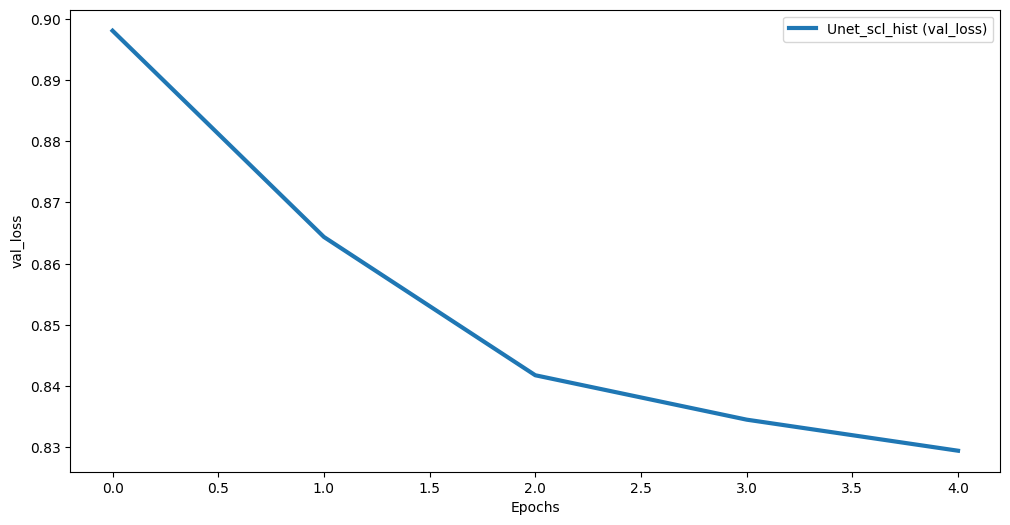

In [59]:
plot_perf(hists,['Unet_scl_hist'],['val_loss'])


This function is designed to reshape and reconstruct images from smaller, previously extracted windows. This is typically used after processing these windows (e.g., after denoising them with a trained model).

**note- i adjusted this cuz i kept getting errors - needs to be checked 

In [81]:
def pred_resh(data, output_size, num_wind, wind_size):
    # Calculate the number of images based on the number of windows per image
    num_images = int(data.shape[0] / num_wind)
    
    # Truncate data to make it fit the expected shape
    trunc_length = num_images * num_wind
    data_trunc = data[:trunc_length]
    
    # Reshape the truncated data
    data_resh = data_trunc.reshape(num_images, num_wind, wind_size, wind_size)
    
    img = []
    for iImg in range(data_resh.shape[0]):
        img.append(windows2img(data_resh[iImg], output_size, output_size))

    img = np.array(img)

    return img 

predimg_Unet_w32 = pred_resh(predUnet_w32, output_size=256, num_wind=64, wind_size=32)



(336, 32, 32, 1)


Okay now we test the data to predict our denoising on the test data 

In essence, this step is about leveraging the trained neural network model to produce denoised outputs for a given set of noisy seismic data samples.

In [66]:
predUnet_w32 = Unet_scl.predict(NS_test_conv_resh_w32)


11/11 [==============================] - 3s 122ms/step


In [ ]:
orig_noisy = NS_test.reshape(396,256,256)
orig_clean = S_test.reshape(396,256,256)

IndexError: index 50 is out of bounds for axis 0 with size 21

<Figure size 1500x1000 with 0 Axes>

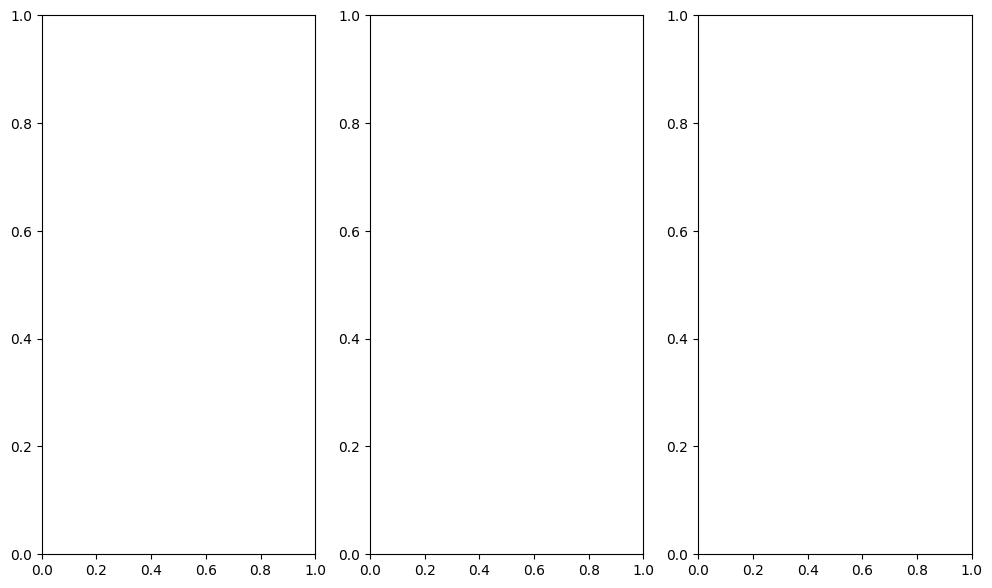

In [82]:
plt.figure(figsize=(15,10))
PlotSeis([orig_clean,orig_noisy,predimg_Unet_w32],num=num)

In [70]:
orig_noisy = NS_test.reshape(21,128,128)
orig_clean = S_test.reshape(21,128,128)
diff_w32_Unet = orig_clean-predUnet_w32


ValueError: operands could not be broadcast together with shapes (21,128,128) (336,32,32,1) 